# Annotation Statistics

## Step 1: Load Libraries

In [1]:
# Install all required packages
!pip install pandas krippendorff statsmodels scikit-learn seaborn matplotlib numpy



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa
import itertools
import seaborn as sns
from scipy.stats import entropy
from sklearn.cluster import KMeans
from scipy.special import rel_entr
from scipy.stats import entropy
import itertools



## Step 2: Read and Prepare Data

In [5]:
df = pd.read_csv("./gold_dataset.csv")

#### **Data Cleaning**

<p> We are going to make changes to the dataframe, so that it follows an easy to read and use format.</p>

<p> First, we note that HITId identifies speeches, WorkerId identifies workers, and Input.label is the annotation </p>


In [ ]:
# only keep needed columns and rename 
df_clean = df[['HITId', 'WorkerId', 'Input.parameter', 'Input.label']].copy() #remove unnecessary columns
df_clean.rename(columns={
    'HITId': 'speech_id',
    'WorkerId': 'worker_id',
    'Input.parameter': 'parameter',
    'Input.label': 'label'
}, inplace=True)

# extra cleaning, dropping nulls, making sure all labels are ints, 
df_clean = df_clean.sort_values(by=['parameter', 'speech_id', 'worker_id']).reset_index(drop=True)

# Final preview

df_clean


,speech_id,worker_id,parameter,label
0,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,A1NBQ61Y6KO3O9,Par303_Governmental and Administrative Efficiency,1
1,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,A3GS2NTQ4XU059,Par303_Governmental and Administrative Efficiency,1
2,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,APXGSUB250NVH,Par303_Governmental and Administrative Efficiency,1
3,31MBOZ6PBB9KPU25XZW1AQD3VXRLCF,A1NBQ61Y6KO3O9,Par303_Governmental and Administrative Efficiency,0
4,31MBOZ6PBB9KPU25XZW1AQD3VXRLCF,A3GS2NTQ4XU059,Par303_Governmental and Administrative Efficiency,0
...,...,...,...,...
655,3WRKFXQBPYPV2WV48OHDF1DUHHFIY6,A1X47COW2Y9SEL,Par701702_LabourGroups,2
656,3WRKFXQBPYPV2WV48OHDF1DUHHFIY6,A335R4YE2E34H6,Par701702_LabourGroups,2
657,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,A1NBQ61Y6KO3O9,Par701702_LabourGroups,2
658,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,A1X47COW2Y9SEL,Par701702_LabourGroups,2


In [44]:
df_clean['label'] = pd.to_numeric(df_clean['label'], errors='coerce')  # force to float
print(df_clean.dtypes)


speech_id    object
worker_id    object
parameter    object
label         int64
dtype: object


Create 10 different tables for each parameter

In [14]:
# # Step 0: Create a compact speech ID (optional, if not already done)
# df['speech_id'] = df['Input.text-eng'].factorize()[0]

# # Step 1: Get list of unique parameters
# parameters = df['Input.parameter'].unique()

# # Step 2: Dictionary to hold each table
# parameter_tables = {}

# # Step 3: Create one table per parameter
# for param in parameters:
#     df_param = df[df['Input.parameter'] == param]

#     # Drop duplicates just in case
#     df_param = df_param.drop_duplicates(subset=['speech_id', 'WorkerId'])

#     # Pivot: rows = speech, columns = workers, values = labels
#     pivot = df_param.pivot(
#         index='speech_id',
#         columns='WorkerId',
#         values='Input.label'
#     )

#     # Optional: attach the actual speech text back for readability
#     pivot = pivot.merge(
#         df[['speech_id', 'Input.text-eng']].drop_duplicates(),
#         on='speech_id',
#         how='left'
#     ).set_index('speech_id')

#     # Store the table
#     parameter_tables[param] = pivot

# parameters
# # parameter_tables['Par411_Technology&Infrastructure']
 

In [89]:
for param in df['Input.parameter'].unique():
    safe_name = "df_" + (
        param.replace('-', '_')
             .replace('&', 'And')
             .replace('.', '')
             .replace(' ', '_')
    )

    df_param = df[df['Input.parameter'] == param].drop_duplicates(subset=['HITId', 'WorkerId'])

    # Pivot without altering index permanently
    pivot = df_param.pivot(
        index='HITId',
        columns='WorkerId',
        values='Input.label'
    ).reset_index()  # <-- Keep HITId as a column

    # Optionally, sort columns so HITId is first
    cols = ['HITId'] + [col for col in pivot.columns if col != 'HITId']
    pivot = pivot[cols]

    globals()[safe_name] = pivot
    print(f"Created variable: {safe_name}")



Created variable: df_Par303_Governmental_and_Administrative_Efficiency
Created variable: df_Par405_Corporatism
Created variable: df_Par402_Incentives
Created variable: df_Par410416_EconomicGrowthAntiGrowth
Created variable: df_Par408_EconomicGoals
Created variable: df_Par409_KeynesianDemandManagement
Created variable: df_Par404_EconomicPlanning
Created variable: df_Par401403_FreeMarket_MarketRegulation
Created variable: df_Par701702_LabourGroups
Created variable: df_Par411_TechnologyAndInfrastructure


## First Try: Krippendorff’s Alpha 

Handles missing data, works for nominal/ordinal; More flexible than Fleiss; can handle ordinal distance metrics too. First we will use Krippendorff's Alpha to compare agreement scores per parameter. 

*Defining the Functions*

In [ ]:
# define dataframes, workers, etc. 
param_dfs = {
    "Par303_Governmental_and_Administrative_Efficiency": df_Par303_Governmental_and_Administrative_Efficiency,
    "Par405_Corporatism": df_Par405_Corporatism,
    "Par402_Incentives": df_Par402_Incentives,
    "Par410416_EconomicGrowthAntiGrowth": df_Par410416_EconomicGrowthAntiGrowth,
    "Par408_EconomicGoals": df_Par408_EconomicGoals,
    "Par409_KeynesianDemandManagement": df_Par409_KeynesianDemandManagement,
    "Par404_EconomicPlanning": df_Par404_EconomicPlanning,
    "Par401403_FreeMarket_MarketRegulation": df_Par401403_FreeMarket_MarketRegulation,
    "Par701702_LabourGroups": df_Par701702_LabourGroups,
    "Par411_TechnologyAndInfrastructure": df_Par411_TechnologyAndInfrastructure
}

workers = [
    'A1BQ37ZGUM16XI', 
    'A1NBQ61Y6KO3O9', 
    'A1X47COW2Y9SEL', 
    'A335R4YE2E34H6', 
    'A3GS2NTQ4XU059', 
    'APXGSUB250NVH'
]

# choose and prep data - will later be inside loop
df_param = df_Par409_KeynesianDemandManagement
ratings = df_param.drop(columns='HITId')

# compute alpha - will later be in loop 
print(f'------------------')
alpha = krippendorff.alpha(reliability_data=ratings, level_of_measurement='nominal')
print(f"Krippendorff’s Alpha: {alpha:.3f}")


Index(['HITId', 'A1NBQ61Y6KO3O9', 'A1X47COW2Y9SEL', 'A335R4YE2E34H6',
       'A3GS2NTQ4XU059', 'APXGSUB250NVH'],
      dtype='object', name='WorkerId')
--------- WorkerId                           HITId  A1NBQ61Y6KO3O9  A1X47COW2Y9SEL  \
0         30OITAWPCDLG50CCUU7CG8JO8IRH99             1.0             1.0   
1         32W3UF2E0B3ORMVKR7XKO9BS9Y8C4Z             1.0             1.0   
2         32XN26MTYM10V27PLJ3HFPB2M8UL0M             1.0             NaN   
3         33P2GD6NSAA0MWV3YRY16HX4JC3HK3             0.0             0.0   
4         351S7I5UHWEXL8BWJ4T2AMUNQZCJNF             1.0             1.0   
5         35A1YQPVG1YX08LKXMCG44F1MCB5ID             NaN             0.0   
6         37OPIVELVHLUAJMHM0LCC3U8E09HAO             0.0             0.0   
7         37PGLWGSKGO0IR6N49GM6TYJJ26KID             0.0             NaN   
8         37YYO3NWI08RMQ8ZKM3277NG1BPCCC             NaN             1.0   
9         38RHULDVALXRDR04TNZPU4SE69FIW7             0.0             NaN   
10

## Second Try: Pairwise Cohen Kappa (not working right now)

standard model but can only compare two annotators; therefore, we take a pair-wise approach and loop through annotator pairs

In [ ]:
# annotators = ratings.columns #specify annotators 
# print('-------------------')

# min_overlap = 10

# for a1, a2 in itertools.combinations(annotators, 2):
#     pair = ratings[[a1, a2]].dropna()
#     if len(pair) >= min_overlap:
#         score = cohen_kappa_score(pair[a1], pair[a2])
#         print(f"{a1} vs {a2}: Cohen's Kappa = {score:.3f} (n={len(pair)})")
#     else:
#         print(f"{a1} vs {a2}: not enough overlap (n={len(pair)})")


In [ ]:


# kappa_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

# for a1, a2 in itertools.combinations(annotators, 2):
#     pair = ratings[[a1, a2]].dropna()
#     if not pair.empty:
#         k = cohen_kappa_score(pair[a1], pair[a2])
#         kappa_matrix.loc[a1, a2] = k
#         kappa_matrix.loc[a2, a1] = k
#     else:
#         kappa_matrix.loc[a1, a2] = None
#         kappa_matrix.loc[a2, a1] = None

# sns.heatmap(kappa_matrix, annot=True, cmap="coolwarm", center=0)
# plt.title("Pairwise Cohen's Kappa")
# plt.show()


Cohen's Kappa will likely not work - even with a pairwise approach. It may be more benificial to do create an aggregate table 

## Third Try: Fleiss' Kappa 

## Annotation Coverage - Other Statistics

How many samples each annotator labeled

In [ ]:
coverage = ratings.notna().sum()
print(coverage)


Input.label_A1BQ37ZGUM16XI      7
Input.label_A1NBQ61Y6KO3O9    186
Input.label_A1X47COW2Y9SEL    128
Input.label_A335R4YE2E34H6    152
Input.label_A3GS2NTQ4XU059    104
Input.label_APXGSUB250NVH      83
dtype: int64


Which annotators skipped what?

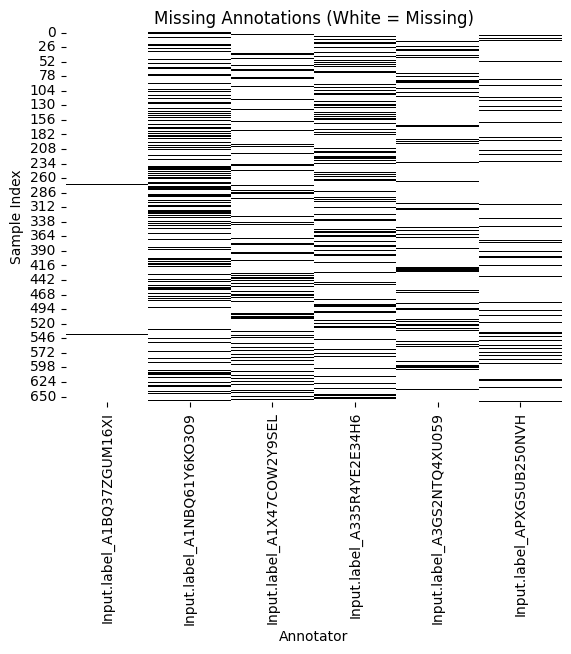

In [ ]:
sns.heatmap(ratings.isna(), cbar=False, cmap='gray')
plt.title("Missing Annotations (White = Missing)")
plt.xlabel("Annotator")
plt.ylabel("Sample Index")
plt.show()

**Label Distribution per Annotator**



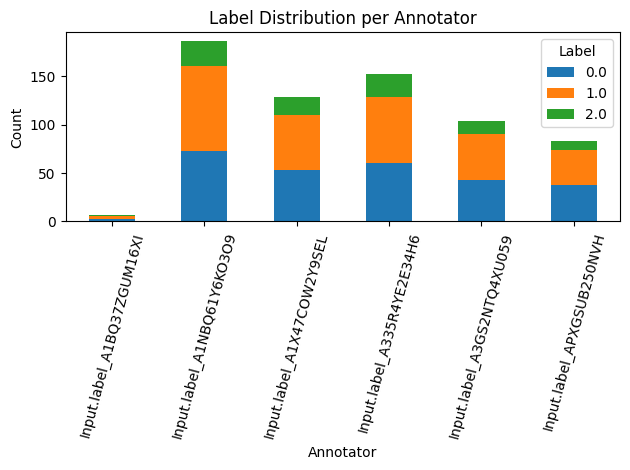

In [ ]:
# label_dist = {col: ratings[col].value_counts(dropna=True) for col in ratings.columns}
# for annotator, dist in label_dist.items():
#     print(f"\n{annotator}:\n{dist}")

label_counts = ratings.apply(lambda col: col.value_counts()).fillna(0).T
label_counts.plot(kind='bar', stacked=True)


plt.title("Label Distribution per Annotator")
plt.xlabel("Annotator")
plt.ylabel("Count")
plt.legend(title="Label")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


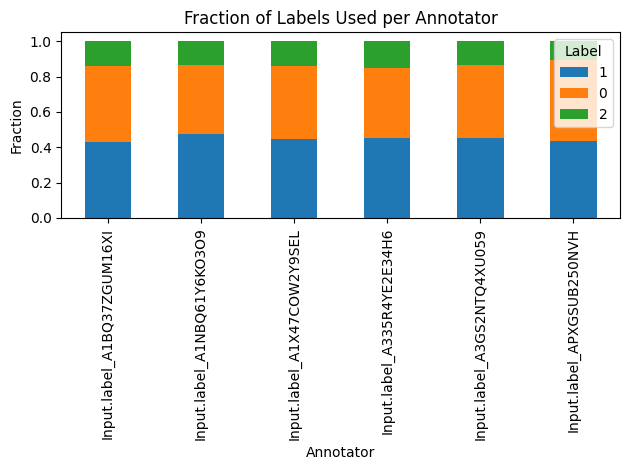

In [ ]:
label_fractions = ratings.apply(lambda col: col.value_counts(normalize=True)).T
label_fractions = label_fractions.reindex(columns=[1, 0, 2]).fillna(0)

label_fractions.plot(kind='bar', stacked=True)
plt.title("Fraction of Labels Used per Annotator")
plt.ylabel("Fraction")
plt.xlabel("Annotator")
plt.xticks(rotation=90)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

How different are annotators' distributions? *KL divergence (Kullback–Leibler divergence) is a way to measure how different one probability distribution is from another.*

In [ ]:
def kl_divergence(p, q):
    '''kl_div helper to avoid division by 0
    '''
    p = np.array(p) + 1e-10
    q = np.array(q) + 1e-10
    return np.sum(rel_entr(p, q))

label_dists = ratings.apply(lambda col: col.value_counts(normalize=True).reindex([0, 1, 2]).fillna(0))

for a1, a2 in itertools.combinations(label_dists.columns, 2):
    kl = kl_divergence(label_dists[a1], label_dists[a2])
    print(f"{a1} vs {a2}: KL Divergence = {kl:.3f}")


Input.label_A1BQ37ZGUM16XI vs Input.label_A1NBQ61Y6KO3O9: KL Divergence = 0.004
Input.label_A1BQ37ZGUM16XI vs Input.label_A1X47COW2Y9SEL: KL Divergence = 0.001
Input.label_A1BQ37ZGUM16XI vs Input.label_A335R4YE2E34H6: KL Divergence = 0.002
Input.label_A1BQ37ZGUM16XI vs Input.label_A3GS2NTQ4XU059: KL Divergence = 0.001
Input.label_A1BQ37ZGUM16XI vs Input.label_APXGSUB250NVH: KL Divergence = 0.006
Input.label_A1NBQ61Y6KO3O9 vs Input.label_A1X47COW2Y9SEL: KL Divergence = 0.002
Input.label_A1NBQ61Y6KO3O9 vs Input.label_A335R4YE2E34H6: KL Divergence = 0.001
Input.label_A1NBQ61Y6KO3O9 vs Input.label_A3GS2NTQ4XU059: KL Divergence = 0.001
Input.label_A1NBQ61Y6KO3O9 vs Input.label_APXGSUB250NVH: KL Divergence = 0.010
Input.label_A1X47COW2Y9SEL vs Input.label_A335R4YE2E34H6: KL Divergence = 0.001
Input.label_A1X47COW2Y9SEL vs Input.label_A3GS2NTQ4XU059: KL Divergence = 0.000
Input.label_A1X47COW2Y9SEL vs Input.label_APXGSUB250NVH: KL Divergence = 0.007
Input.label_A335R4YE2E34H6 vs Input.label_A

Do annotators agree with the majority ?

In [ ]:
majority_vote = ratings.mode(axis=1)[0]

for annotator in ratings.columns:
    match = (ratings[annotator] == majority_vote) & ratings[annotator].notna()
    pct_agree = match.sum() / ratings[annotator].notna().sum()
    print(f"{annotator} agreement with majority: {pct_agree:.2%}")


Input.label_A1BQ37ZGUM16XI agreement with majority: 100.00%
Input.label_A1NBQ61Y6KO3O9 agreement with majority: 100.00%
Input.label_A1X47COW2Y9SEL agreement with majority: 100.00%
Input.label_A335R4YE2E34H6 agreement with majority: 100.00%
Input.label_A3GS2NTQ4XU059 agreement with majority: 100.00%
Input.label_APXGSUB250NVH agreement with majority: 100.00%
